# Step 1: Cloning and Building Darknet




In [ ]:
# clone darknet repo
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 14924, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 14924 (delta 21), reused 34 (delta 20), pack-reused 14880
Receiving objects: 100% (14924/14924), 13.37 MiB | 22.70 MiB/s, done.
Resolving deltas: 100% (10139/10139), done.


In [ ]:
# change makefile to have GPU and OPENCV enabled
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile

/content/darknet


In [ ]:
# verifying if CUDA is supported
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0


In [ ]:
# build darknet
!make

mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:926:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1127:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old == 0)
             ^~
./src/image_

# Step 2: Defining some helper functions and connecting to Google Drive
Colab does not support cv2.imshow() function natively

In [ ]:
# define helper functions
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

In [ ]:
# connecting to Google Drive
%cd ..
from google.colab import drive
drive.mount('/content/gdrive')

/content
Mounted at /content/gdrive


In [ ]:
# this creates a symbolic link so that now the path /content/gdrive/My\ Drive/ is equal to /mydrive
!ln -s /content/gdrive/My\ Drive/ /mydrive

# Step 3: Training a YOLOv3 Model

Gathering Images

In [ ]:
%cd darknet
#To Train the model, I have downloaded 1500 labelled images of Weapon and uploaded it to my Google Drive
!ls /mydrive/yolo-2

/content/darknet
backup	obj.data  obj.names  obj.zip  yolov3_custom.cfg


In [ ]:
#copying labelled images of Weapon as a zip into colab
!cp /mydrive/yolo-2/obj.zip ../

In [ ]:
# unzip the zip file and its contents should now be in /darknet/data/obj
!unzip ../obj.zip -d data/

Streaming output truncated to the last 5000 lines.
  inflating: data/obj/den-of-thieves2018-final-gun-fight-with-police-movie-cube06821.jpg  
  inflating: data/obj/den-of-thieves2018-final-gun-fight-with-police-movie-cube06821.txt  
  inflating: data/obj/den-of-thieves2018-final-gun-fight-with-police-movie-cube06831.jpg  
  inflating: data/obj/den-of-thieves2018-final-gun-fight-with-police-movie-cube06831.txt  
  inflating: data/obj/den-of-thieves2018-final-gun-fight-with-police-movie-cube06841.jpg  
  inflating: data/obj/den-of-thieves2018-final-gun-fight-with-police-movie-cube06841.txt  
  inflating: data/obj/den-of-thieves2018-final-gun-fight-with-police-movie-cube06851.jpg  
  inflating: data/obj/den-of-thieves2018-final-gun-fight-with-police-movie-cube06851.txt  
  inflating: data/obj/den-of-thieves2018-final-gun-fight-with-police-movie-cube06861.jpg  
  inflating: data/obj/den-of-thieves2018-final-gun-fight-with-police-movie-cube06861.txt  
  inflating: data/obj/den-of-thieves201

Gathering YOLOv3 Config Files

In [ ]:
# upload the custom .cfg back to colab from Google Drive
!cp /mydrive/yolo-2/yolov3_custom.cfg ./cfg

In [ ]:
# upload the obj.names and obj.data files to colab from Google Drive
!cp /mydrive/yolo-2/obj.names ./data
!cp /mydrive/yolo-2/obj.data  ./data

In [ ]:
# Generating train.txt, which hold the relative paths to all our training images
import os

image_files = []
os.chdir(os.path.join("data", "obj"))
for filename in os.listdir(os.getcwd()):
    if filename.endswith(".jpg"):
        image_files.append("data/obj/" + filename)
os.chdir("..")
with open("train.txt", "w") as outfile:
    for image in image_files:
        outfile.write(image)
        outfile.write("\n")
    outfile.close()
os.chdir("..")

In [ ]:
# verify files - obj.names, obj.data, train.txt can be seen in our darknet/data folder
!ls data/

9k.tree     eagle.jpg	 imagenet.labels.list	   obj.data	     scream.jpg
coco9k.map  giraffe.jpg  imagenet.shortnames.list  obj.names	     train.txt
coco.names  goal.txt	 labels			   openimages.names  voc.names
dog.jpg     horses.jpg	 obj			   person.jpg


Downloading pre-trained weights for the convolutional layers

In [ ]:
!wget http://pjreddie.com/media/files/darknet53.conv.74

--2021-04-16 05:55:49--  http://pjreddie.com/media/files/darknet53.conv.74
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pjreddie.com/media/files/darknet53.conv.74 [following]
--2021-04-16 05:55:49--  https://pjreddie.com/media/files/darknet53.conv.74
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162482580 (155M) [application/octet-stream]
Saving to: ‘darknet53.conv.74’

darknet53.conv.74   100%[===================>] 154.96M  44.6MB/s    in 3.8s    

2021-04-16 05:55:53 (40.5 MB/s) - ‘darknet53.conv.74’ saved [162482580/162482580]



Training our model

In [ ]:
!./darknet detector train data/obj.data cfg/yolov3_custom.cfg darknet53.conv.74 -dont_show
# i wont be running this cell because i have already trained my model

Streaming output truncated to the last 5000 lines.
 total_bbox = 496576, rewritten_bbox = 0.479282 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.765006), count: 4, class_loss = 0.396934, iou_loss = 0.217975, total_loss = 0.614909 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 94 Avg (IOU: 0.603164), count: 2, class_loss = 0.282178, iou_loss = 0.286022, total_loss = 0.568200 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 106 Avg (IOU: 0.000000), count: 1, class_loss = 0.002215, iou_loss = 0.000000, total_loss = 0.002215 
 total_bbox = 496582, rewritten_bbox = 0.479276 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.833390), count: 3, class_loss = 0.214268, iou_loss = 0.056846, total_loss = 0.271114 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 94 Avg (IOU: 0.780578), count: 8, class_loss = 0.187366, iou_loss = 0.418744, total_loss = 0.606110 
v3 (ms

In [ ]:
#continuing the training using last saved weights
!./darknet detector train data/obj.data cfg/yolov3_custom.cfg /mydrive/yolo/backup/yolov3_custom_last.weights -dont_show -map

Streaming output truncated to the last 5000 lines.
 total_bbox = 14061, rewritten_bbox = 0.341370 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.831654), count: 2, class_loss = 0.047306, iou_loss = 0.082372, total_loss = 0.129677 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 94 Avg (IOU: 0.582214), count: 3, class_loss = 0.493315, iou_loss = 0.355044, total_loss = 0.848359 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 106 Avg (IOU: 0.000000), count: 1, class_loss = 0.000054, iou_loss = 0.000000, total_loss = 0.000054 
 total_bbox = 14066, rewritten_bbox = 0.341248 % 

 2128: 0.463053, 0.553553 avg loss, 0.001000 rate, 4.986343 seconds, 136192 images, 2.698721 hours left
Loaded: 0.000040 seconds
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.854704), count: 2, class_loss = 0.072042, iou_loss = 0.060834, total_loss = 0.132875 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.0

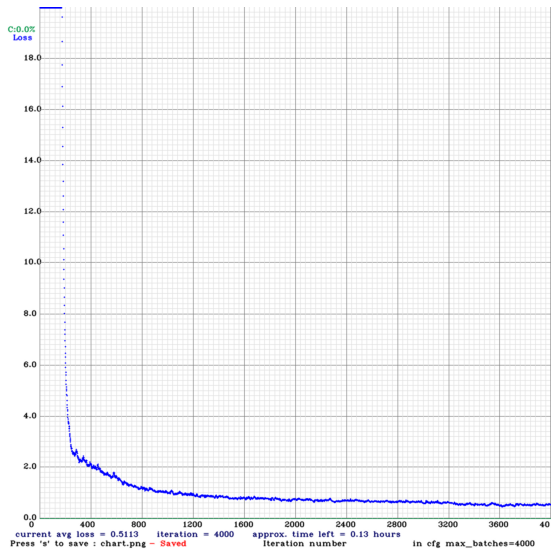

In [ ]:
imShow('chart.png')

In [ ]:
# copying the chart to my drive
!cp chart.png /mydrive/yolo/

# Step 4: Testing 

In [ ]:
# need to set our custom cfg to test mode 
%cd cfg
!sed -i 's/batch=64/batch=1/' yolov3_custom.cfg
!sed -i 's/subdivisions=16/subdivisions=1/' yolov3_custom.cfg
%cd ..

/content/darknet/cfg
/content/darknet


 CUDA-version: 11000 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5,  

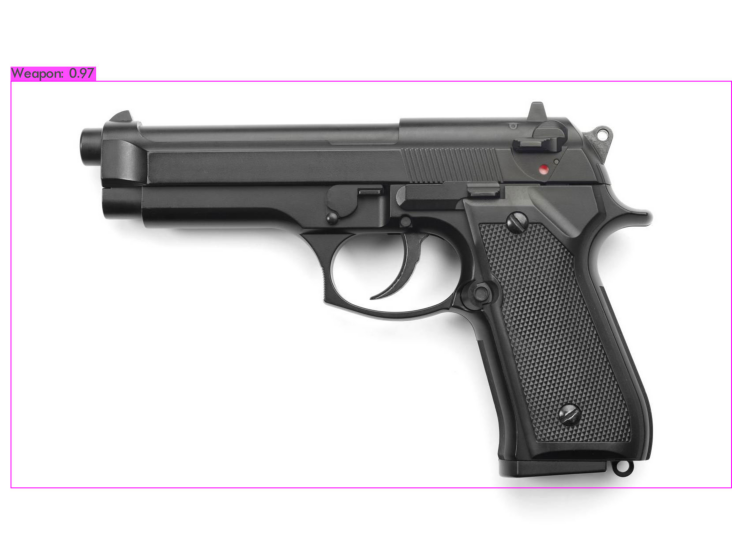

In [ ]:
#Testing the model on a gun image
!./darknet detector test data/obj.data cfg/yolov3_custom.cfg /mydrive/yolo-2/backup/yolov3_custom_last.weights /mydrive/yolo/images/gun.jpg
imShow('predictions.jpg')

 CUDA-version: 11000 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5,  

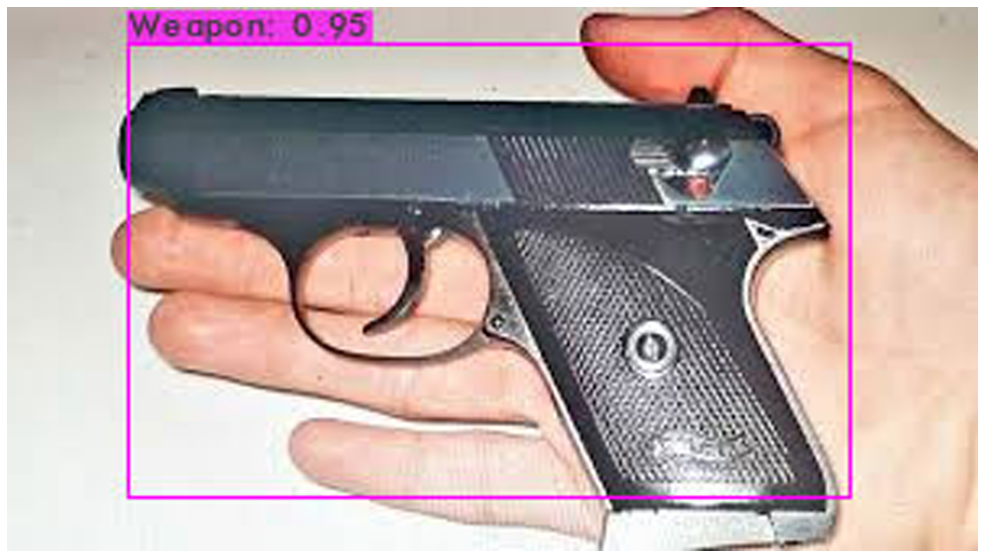

In [ ]:
#Testing the model on another gun image
!./darknet detector test data/obj.data cfg/yolov3_custom.cfg /mydrive/yolo-2/backup/yolov3_custom_last.weights /mydrive/yolo/images/gun2.jpg
imShow('predictions.jpg')

In [ ]:
#Testing the model on a CCTV video
!./darknet detector demo data/obj.data cfg/yolov3_custom.cfg /mydrive/yolo-2/backup/yolov3_custom_last.weights -dont_show /mydrive/yolo/images/1.mp4 -i 0 -out_filename /mydrive/yolo-2/images/result1.avi -thresh 0.4

Streaming output truncated to the last 5000 lines.

 cvWriteFrame 
Objects:


FPS:27.1 	 AVG_FPS:25.9

 cvWriteFrame 
Objects:


FPS:27.0 	 AVG_FPS:25.9

 cvWriteFrame 
Objects:


FPS:26.7 	 AVG_FPS:25.9

 cvWriteFrame 
Objects:


FPS:26.4 	 AVG_FPS:25.9

 cvWriteFrame 
Objects:


FPS:27.6 	 AVG_FPS:25.9

 cvWriteFrame 
Objects:


FPS:28.9 	 AVG_FPS:25.9

 cvWriteFrame 
Objects:


FPS:29.9 	 AVG_FPS:25.9

 cvWriteFrame 
Objects:


FPS:30.1 	 AVG_FPS:25.9

 cvWriteFrame 
Objects:


FPS:31.2 	 AVG_FPS:25.9

 cvWriteFrame 
Objects:


FPS:30.5 	 AVG_FPS:25.9

 cvWriteFrame 
Objects:


FPS:29.4 	 AVG_FPS:25.9

 cvWriteFrame 
Objects:


FPS:28.4 	 AVG_FPS:25.9

 cvWriteFrame 
Objects:

Weapon: 55% 

FPS:29.5 	 AVG_FPS:25.9

 cvWriteFrame 
Objects:

Weapon: 58% 

FPS:30.8 	 AVG_FPS:25.9

 cvWriteFrame 
Objects:

Weapon: 58% 

FPS:30.2 	 AVG_FPS:25.9

 cvWriteFrame 
Objects:

Weapon: 57% 

FPS:29.0 	 AVG_FPS:25.9

 cvWriteFrame 
Objects:

Weapon: 51% 

FPS:28.9 	 AVG_FPS:25.9

 cvWriteFrame 
O

In [ ]:
# Testing the model on another CCTV video
!./darknet detector demo data/obj.data cfg/yolov3_custom.cfg /mydrive/yolo-2/backup/yolov3_custom_last.weights -dont_show /mydrive/yolo/images/2.mp4 -i 0 -out_filename /mydrive/yolo-2/images/result2.avi -thresh 0.5

 CUDA-version: 11000 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
Demo
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer:

In [ ]:
# Testing the model on another CCTV video
!./darknet detector demo data/obj.data cfg/yolov3_custom.cfg /mydrive/yolo-2/backup/yolov3_custom_last.weights -dont_show /mydrive/yolo-2/images/4.mp4 -i 0 -out_filename /mydrive/yolo-2/images/result3.avi -thresh 0.2

 CUDA-version: 11000 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
Demo
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: